In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from datetime import datetime, timedelta


In [3]:
data = pd.read_csv('traffic_2hr_intervals.csv')

In [4]:
data = pd.read_csv('traffic_2hr_intervals.csv')

data = data.sort_values(by=['location', 'datetime'])

scaler = MinMaxScaler()
data[['flow', 'occupy', 'speed']] = scaler.fit_transform(data[['flow', 'occupy', 'speed']])

n_timesteps = 12  

In [5]:
X, Y = [], []

# Generate sequences for each location
for location in data['location'].unique():
    location_data = data[data['location'] == location]
    location_data_array = location_data[['flow', 'occupy', 'speed']].values  # Extract features

    # Create sliding window sequences
    for i in range(n_timesteps, len(location_data_array)):
        X.append(location_data_array[i-n_timesteps:i])  # Previous `n_timesteps`
        Y.append(location_data_array[i, 0])  # Predict `flow`

# Convert to numpy arrays
X = np.array(X)
Y = np.array(Y)

In [6]:
print("X shape:", X.shape)  # [samples, timesteps, features]
print("Y shape:", Y.shape)  # [samples]

X shape: (124440, 12, 3)
Y shape: (124440,)


In [7]:
TRAIN_SIZE = 0.8
train_size = int(len(X) * TRAIN_SIZE)
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

print("Train shapes:", X_train.shape, Y_train.shape)
print("Test shapes:", X_test.shape, Y_test.shape)

Train shapes: (99552, 12, 3) (99552,)
Test shapes: (24888, 12, 3) (24888,)


In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(n_timesteps, X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))  # Dropout for regularization
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1))  # Dense layer for prediction
model.compile(optimizer='adam', loss='mean_absolute_error')

/opt/anaconda3/envs/rnn/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(64, input_shape=(n_timesteps, X.shape[2]), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_absolute_error')

/opt/anaconda3/envs/rnn/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,497 (197.25 KB)

 Trainable params: 50,497 (197.25 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the model
model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, Y_test)
print("Test Loss:", loss)

# Predict flow on the test set
predictions = model.predict(X_test)

# Optionally inverse-transform predictions
predictions_rescaled = scaler.inverse_transform(
    np.hstack((predictions, np.zeros((predictions.shape[0], 2))))
)[:, 0]
print("Predictions (rescaled):", predictions_rescaled)

Epoch 1/20
2489/2489 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0629 - val_loss: 0.0333
Epoch 2/20
2489/2489 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0330 - val_loss: 0.0262
Epoch 3/20
2489/2489 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0298 - val_loss: 0.0244
Epoch 4/20
2489/2489 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0285 - val_loss: 0.0225
Epoch 5/20
2489/2489 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0271 - val_loss: 0.0232
Epoch 6/20
2489/2489 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0262 - val_loss: 0.0229
Epoch 7/20
2489/2489 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0252 - val_loss: 0.0215
Epoch 8/20
2489/2489 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.0246 - val_loss: 0.0236
Epoch 9/20
2489/2489 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0240 - val_loss: 0.0209
Epoch 10/20
2489/2489 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0233 - val_loss: 0.0208
Epoch 11/20
2489/2489 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0228 - val_loss: 0.0204
Epoch 12/20
2489/24

In [32]:
predictions_rescaled = scaler.inverse_transform(
    np.hstack((predictions, np.zeros((predictions.shape[0], 2))))
)[:, 0]

# Optionally inverse-transform the true values
true_rescaled = scaler.inverse_transform(
    np.hstack((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], 2))))
)[:, 0]


# Compute Metrics
mae = mean_absolute_error(true_rescaled, predictions_rescaled)
mse = mean_squared_error(true_rescaled, predictions_rescaled)
rmse = np.sqrt(mse)

print("Predictions (rescaled):", predictions_rescaled)
print("True Values (rescaled):", true_rescaled)
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

Predictions (rescaled): [212.98500012 169.4739932  218.13953077 ...  38.2639416   21.5462972
  12.43948252]
True Values (rescaled): [224.91666667 195.79166667 270.83333333 ...  35.375       25.375
   4.91666667]
MAE: 15.60
MSE: 690.67
RMSE: 26.28


In [36]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

def plot_actual_vs_predictedcut123(location):
    start = 0
    end = 13
    # Filter the data for the specified location
    location_data = data[data['location'] == location]
    location_data = location_data.sort_values(by='datetime')

    if len(location_data) < n_timesteps:
        print(f"Insufficient data for location {location}.")
        return

    X_location = []
    Y_actual = []

    for i in range(n_timesteps, len(location_data)):
        X_location.append(location_data[['flow', 'occupy', 'speed']].iloc[i-n_timesteps:i].values)
        Y_actual.append(location_data[['flow']].iloc[i].values[0])

    X_location = np.array(X_location)
    Y_actual = np.array(Y_actual)

    predictions = model.predict(X_location)

    predictions_rescaled = scaler.inverse_transform(
        np.hstack((predictions, np.zeros((predictions.shape[0], 2))))
    )[:, 0]

    Y_actual_rescaled = scaler.inverse_transform(
        np.hstack((Y_actual.reshape(-1, 1), np.zeros((Y_actual.shape[0], 2))))
    )[:, 0]

    datetime_range = location_data['datetime'].iloc[n_timesteps:].values[start:end]  # Limit to first 12 values

    Y_actual_rescaled = Y_actual_rescaled[start:end]
    predictions_rescaled = predictions_rescaled[start:end]

    plt.figure(figsize=(10, 6))
    plt.plot(datetime_range, Y_actual_rescaled, label='Actual Flow', color='green', linewidth=2)
    plt.plot(datetime_range, predictions_rescaled, label='Predicted Flow', color='blue', linestyle='--', linewidth=2)

    # Format x-axis with datetime ticks
    # plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))  # Set major ticks every 2 hours
    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))  # Format the datetime labels

    # Rotate x-axis ticks
    plt.xticks(rotation=45, ha='right')

    plt.xlabel('Datetime')
    plt.ylabel('Traffic Flow')
    plt.title(f'Actual vs Predicted Traffic Flow for Location {location}')
    plt.legend()

    # Adjust layout to prevent label truncation
    plt.tight_layout()
    plt.show()


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


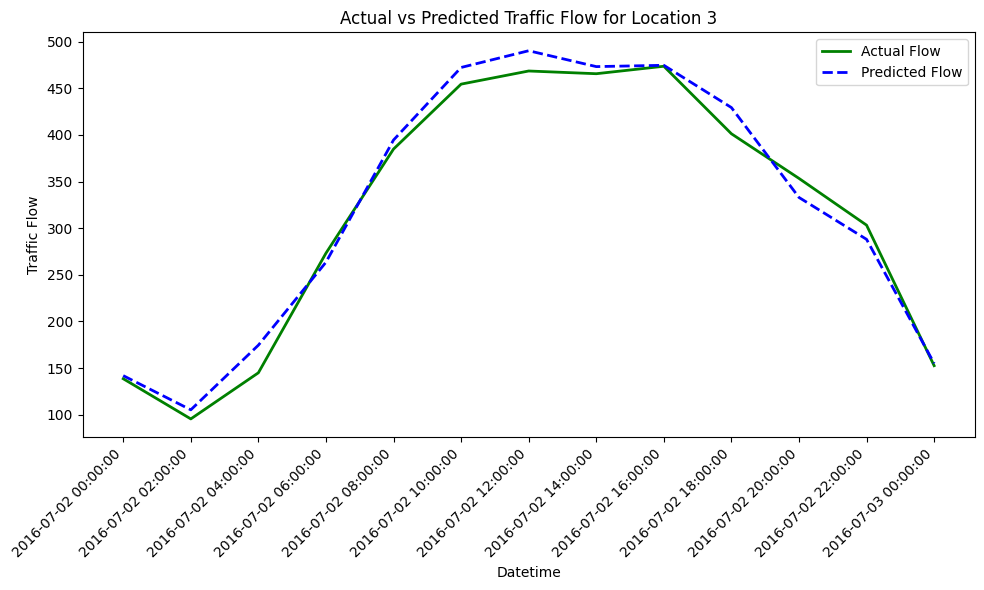

In [41]:
plot_actual_vs_predictedcut123(3)

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, for better-looking plots

def plot_error_distribution(location):
    # Filter the data for the specified location
    location_data = data[data['location'] == location]
    location_data = location_data.sort_values(by='datetime')

    if len(location_data) < n_timesteps:
        print(f"Insufficient data for location {location}.")
        return

    X_location = []
    Y_actual = []

    for i in range(n_timesteps, len(location_data)):
        X_location.append(location_data[['flow', 'occupy', 'speed']].iloc[i-n_timesteps:i].values)
        Y_actual.append(location_data[['flow']].iloc[i].values[0])

    X_location = np.array(X_location)
    Y_actual = np.array(Y_actual)

    # Predict values using the model
    predictions = model.predict(X_location)

    # Inverse-transform the predictions and actual values
    predictions_rescaled = scaler.inverse_transform(
        np.hstack((predictions, np.zeros((predictions.shape[0], 2))))
    )[:, 0]

    Y_actual_rescaled = scaler.inverse_transform(
        np.hstack((Y_actual.reshape(-1, 1), np.zeros((Y_actual.shape[0], 2))))
    )[:, 0]

    # Calculate error distribution
    errors = Y_actual_rescaled - predictions_rescaled

    # Plot the error distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True, color='purple', bins=30)  # KDE is optional for a smoothed line
    plt.xlabel('Error (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.title(f'Error Distribution for Location {location}')
    plt.tight_layout()
    plt.show()


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


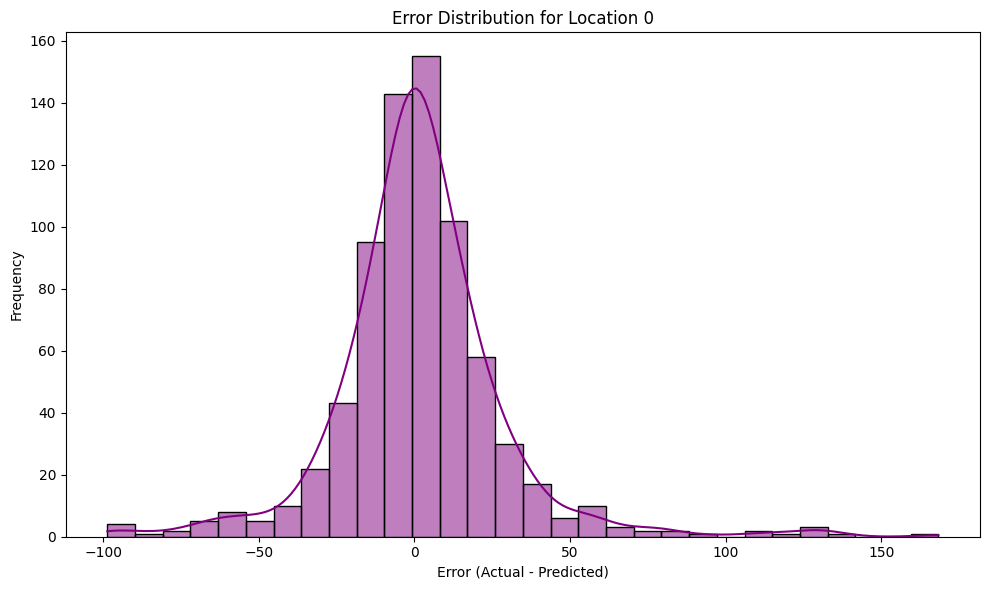

In [35]:
plot_error_distribution(0)